In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


In [2]:
%load_ext autoreload
%autoreload 2

# This tutorial explains the basic pipline of Agentnet experiment
* experiment setup
* designing agent
* interacting with environment
* computing losses
* training

# Experiment setup
* Here we load a simple experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [3]:
import agentnet.experiments.boolean_reasoning as experiment
print experiment.__doc__


This is a dummy experiment setup that requires agent to make advantage of
a simple logical formula in order to maximize expected reward.

The world agent exists in has a number of boolean hidden factors:
X1, X2, X3, Y1, Y2.

The factors are not independent. Namely,
 - Y1 is true if X1
 - Y2 is true if not X1

In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +1 reward for X*, +3 for Y*
   - Otherwise, the reward equals -1 for X*, -3 for Y*
   - checking a single factor more than once a session will result in -0.5 reward for every attempt but for first one
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in order to maximize it's expected reward, the agent
will learn the policy
1. Check X1
2. If X1, check Y1, else Y2

The experiment 

In [4]:
#Create an environment with all default parameters
env = experiment.BooleanReasoningEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, a single one-step RNN
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import RecurrentMemoryLayer
from agentnet.agent import Agent

In [6]:
import lasagne

#64 hidden neurons
n_hid=64


observation_size = (None,)+tuple(env.observation_shapes)

observation_layer = lasagne.layers.InputLayer(observation_size,name="obs_input")
prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")

#memory
#note that this isn't the same as lasagne recurrent units (see next text tab for detail)
rnn = RecurrentMemoryLayer(prev_state_layer,
                           observation_layer,
                           name="rnn0")

#q_eval
q_eval = lasagne.layers.DenseLayer(rnn,
                                   num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")

#resolver
epsilon = theano.shared(np.float32(0.1),name="e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(observation_layer,
              {rnn:prev_state_layer},
              q_eval,resolver)


In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[rnn0.hid_to_hid.W,
 rnn0.hid_to_hid.b,
 rnn0.input0_to_hid.W,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* Such sessions are represented as tensors with dimensions matching pattern [batch_session_i, time_tick, ...]
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [8]:
#produce interaction sequences of length <= 10
(state_seq,),observation_seq,agent_state,action_seq,qvalues_seq = agent.get_sessions(
    env,
    session_length=10,
    batch_size=env.batch_size,
)


hidden_seq = agent_state[rnn]

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


# Evaluating loss function
* In this case, we want to 
 * first get pairs of (predicted Qvalue, reference Qvalue) for all actions commited
 * second, define loss function
 * third, compute grad and update weights

#### Define loss functions

In [9]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning


#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(1),name = 'q_learning_gamma')


squarred_Qerror = qlearning.get_elementwise_objective(
    qvalues_seq,
    action_seq,
    rewards_seq,
    is_alive_seq,
    gamma_or_gammas=gamma,)


mse_Qloss = squarred_Qerror.sum(axis = 1).mean()

In [10]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-3

In [11]:
loss = mse_Qloss + reg_l2

#### Compute weight updates

In [12]:
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.1)

#### Some auxilary evaluation metrics

In [13]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [14]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_Qloss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [15]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   action_names=env.feature_names,
                  
                  plot_policy = with_plots)

session # 0
 End_session_now(qv = 0.331659406424) -> 0.0 | 



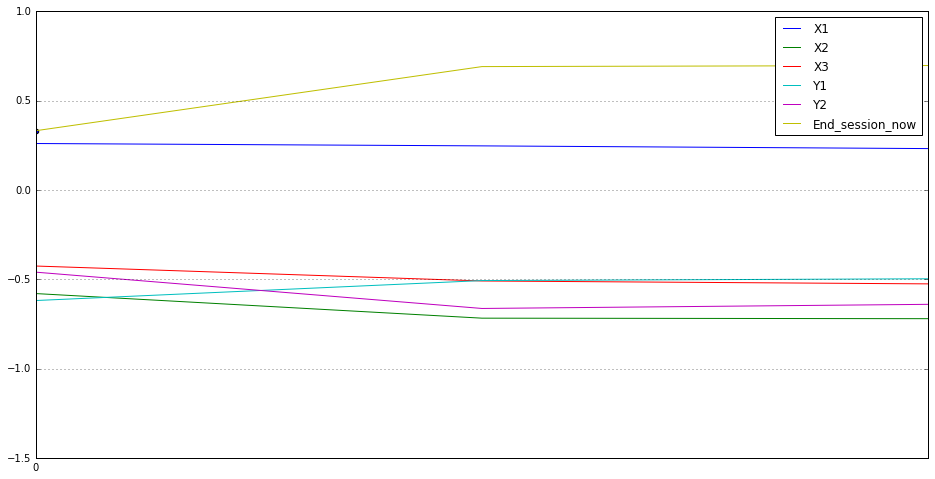

In [16]:
#visualize untrained network performance (which is mostly random)
env.generate_new_data_batch(1)
display_sessions(with_plots=True)

# Training loop

In [17]:
from agentnet.display import Metrics
score_log = Metrics()

In [18]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 100,loss 8.98400, epsilon 0.96275, rewards: ( e-greedy -0.05500, greedy -0.02000) 
rec 8.894 reg 0.090
epoch 200,loss 10.59006, epsilon 0.92696, rewards: ( e-greedy -0.06950, greedy 0.02200) 
rec 10.500 reg 0.090
epoch 300,loss 3.84758, epsilon 0.89257, rewards: ( e-greedy -0.02755, greedy -0.00020) 
rec 3.758 reg 0.089
epoch 400,loss 9.82929, epsilon 0.85954, rewards: ( e-greedy -0.15479, greedy 0.12982) 
rec 9.741 reg 0.089
epoch 500,loss 7.46014, epsilon 0.82779, rewards: ( e-greedy -0.17932, greedy 0.26684) 
rec 7.372 reg 0.088
epoch 600,loss 8.76456, epsilon 0.79730, rewards: ( e-greedy -0.16138, greedy 0.28015) 
rec 8.676 reg 0.088
epoch 700,loss 9.66413, epsilon 0.76799, rewards: ( e-greedy -0.21525, greedy 0.13214) 
rec 9.576 reg 0.088
epoch 800,loss 8.13911, epsilon 0.73984, rewards: ( e-greedy -0.25372, greedy 0.28892) 
rec 8.051 reg 0.088
epoch 900,loss 7.00492, epsilon 0.71279, rewards: ( e-greedy -0.23335, greedy 0.14003) 
rec 6.917 reg 0.088
epoch 1000,loss 8.92265,

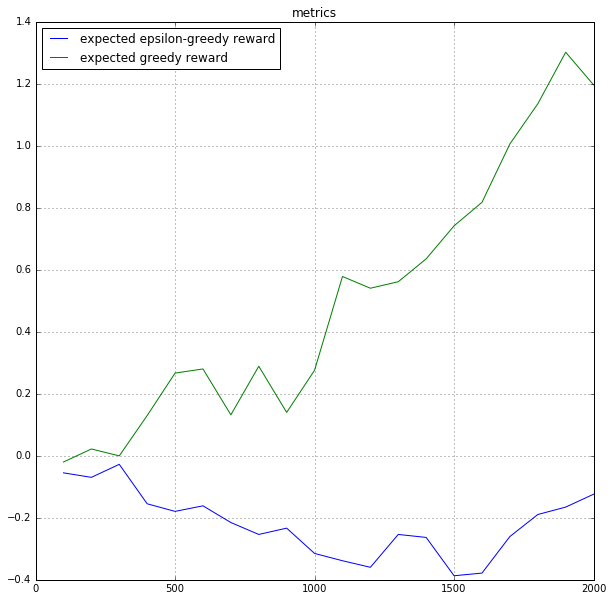

Random session examples
session # 0
 X1(qv = 0.609239280224) -> -1.0 |  X2(qv = -0.0100508108735) -> 1.0 |  End_session_now(qv = 0.0231112018228) -> 0.0 | 



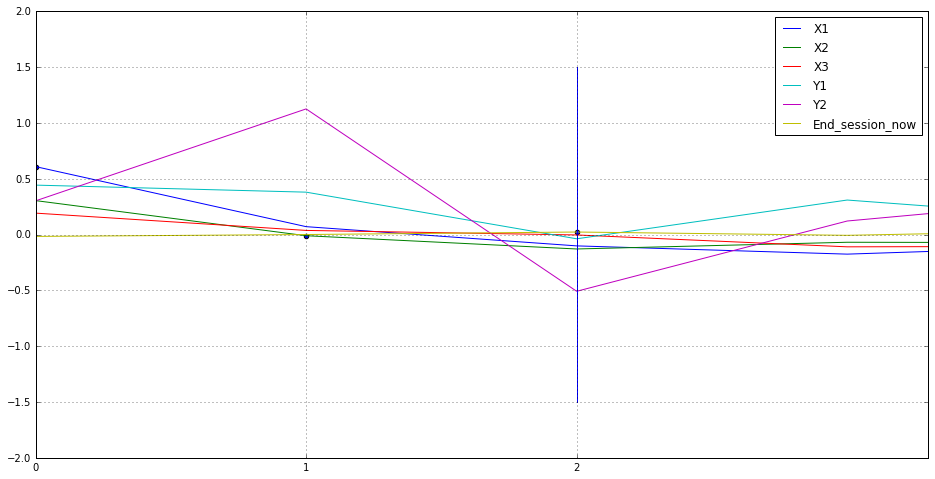

session # 1
 X1(qv = 0.609239280224) -> -1.0 |  X2(qv = -0.0100508108735) -> -1.0 |  Y2(qv = 0.463647544384) -> 3.0 |  Y1(qv = -0.000640198588371) -> -3.0 |  Y1(qv = 0.109686747193) -> -0.5 |  Y2(qv = 0.317302286625) -> -0.5 |  End_session_now(qv = -0.00456804037094) -> 0.0 | 



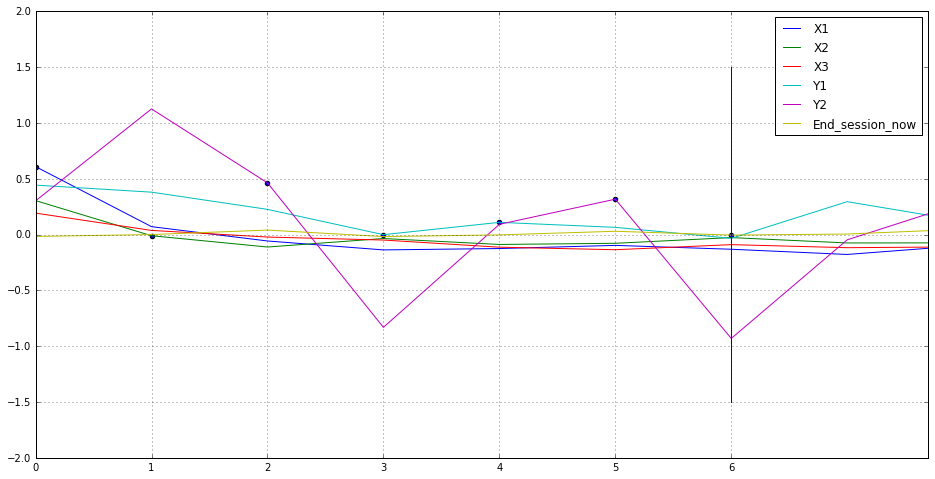

session # 2
 X3(qv = 0.192460983992) -> -1.0 |  X2(qv = 0.0101696774364) -> 1.0 |  End_session_now(qv = 0.00897042453289) -> 0.0 | 



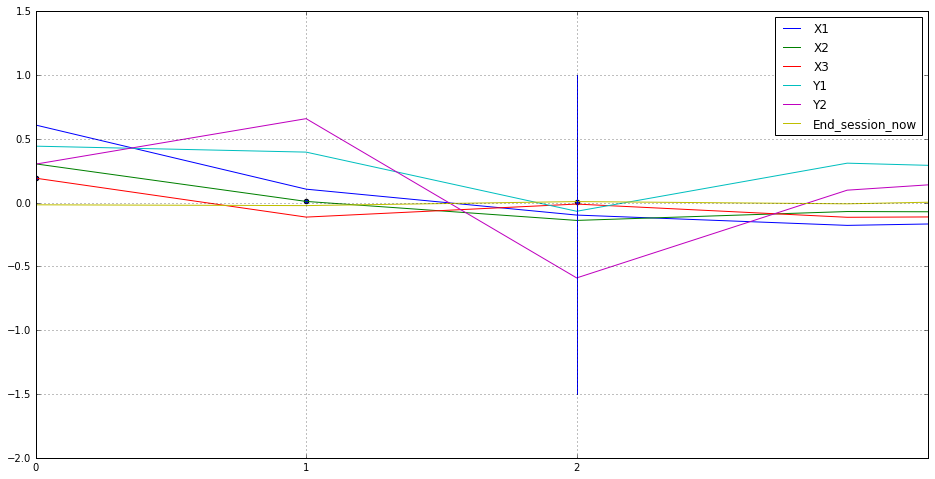

epoch 2100,loss 10.57241, epsilon 0.46012, rewards: ( e-greedy -0.06154, greedy 1.25693) 
rec 10.476 reg 0.096
epoch 2200,loss 9.20733, epsilon 0.44404, rewards: ( e-greedy 0.10962, greedy 1.43124) 
rec 9.109 reg 0.098
epoch 2300,loss 7.86559, epsilon 0.42859, rewards: ( e-greedy 0.12866, greedy 1.35812) 
rec 7.765 reg 0.101
epoch 2400,loss 10.90296, epsilon 0.41375, rewards: ( e-greedy 0.18579, greedy 1.32230) 
rec 10.799 reg 0.104
epoch 2500,loss 5.46320, epsilon 0.39949, rewards: ( e-greedy 0.26221, greedy 1.49007) 
rec 5.357 reg 0.107
epoch 2600,loss 6.65211, epsilon 0.38578, rewards: ( e-greedy 0.20599, greedy 1.32607) 
rec 6.543 reg 0.109
epoch 2700,loss 5.50572, epsilon 0.37262, rewards: ( e-greedy 0.33039, greedy 1.52346) 
rec 5.394 reg 0.112
epoch 2800,loss 4.21889, epsilon 0.35997, rewards: ( e-greedy 0.49735, greedy 1.69111) 
rec 4.104 reg 0.114
epoch 2900,loss 6.79332, epsilon 0.34781, rewards: ( e-greedy 0.64262, greedy 1.82200) 
rec 6.678 reg 0.116
epoch 3000,loss 3.83241

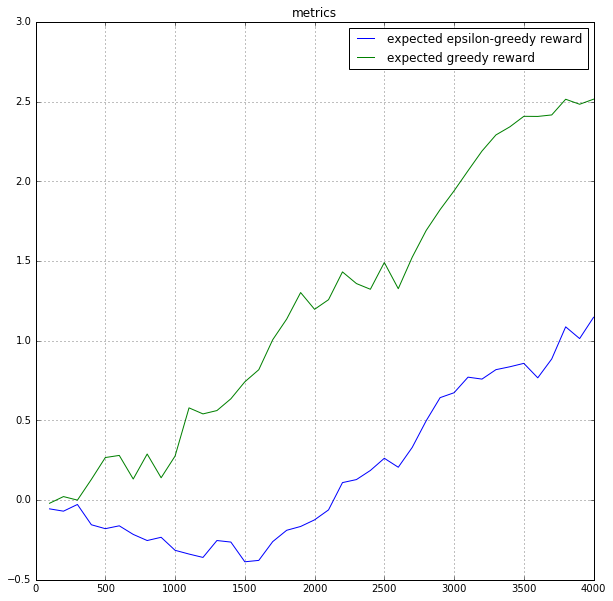

Random session examples
session # 0
 X1(qv = 2.53902316093) -> 1.0 |  Y1(qv = 2.2614774704) -> 3.0 |  X2(qv = 0.0230224765837) -> -1.0 |  Y2(qv = -0.861635744572) -> -3.0 |  End_session_now(qv = 0.0108614144847) -> 0.0 | 



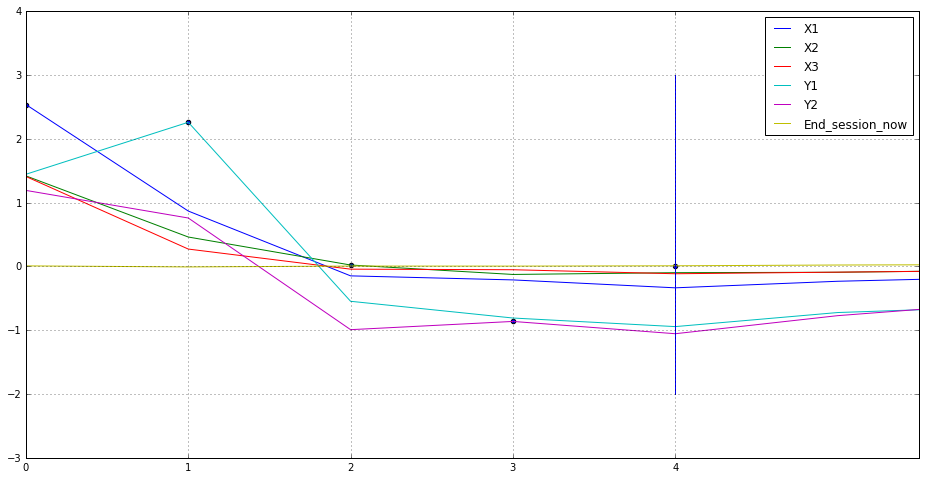

session # 1
 X1(qv = 2.53902316093) -> -1.0 |  Y2(qv = 2.69252943993) -> 3.0 |  X2(qv = 0.0503869690001) -> -1.0 |  End_session_now(qv = 0.000422879122198) -> 0.0 | 



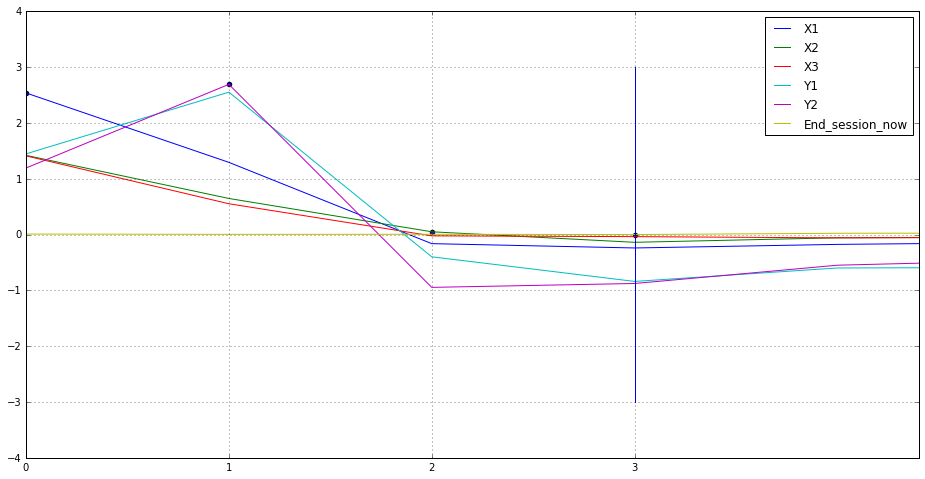

session # 2
 X1(qv = 2.53902316093) -> 1.0 |  Y1(qv = 2.2614774704) -> 3.0 |  X2(qv = 0.0230223871768) -> -1.0 |  End_session_now(qv = 0.00579184573144) -> 0.0 | 



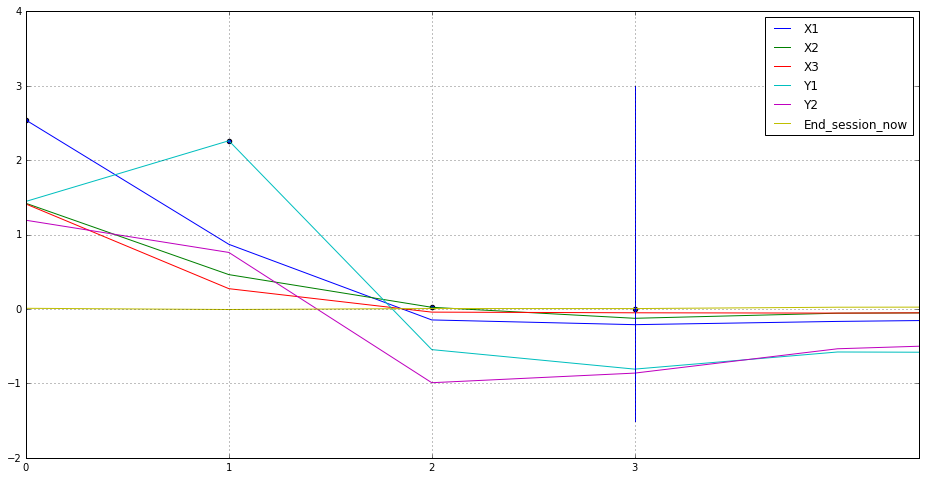

epoch 4100,loss 4.71317, epsilon 0.23428, rewards: ( e-greedy 1.26701, greedy 2.56306) 
rec 4.583 reg 0.130
epoch 4200,loss 1.68177, epsilon 0.22706, rewards: ( e-greedy 1.37031, greedy 2.54676) 
rec 1.550 reg 0.131
epoch 4300,loss 4.65372, epsilon 0.22011, rewards: ( e-greedy 1.35828, greedy 2.59208) 
rec 4.521 reg 0.132
epoch 4400,loss 3.11435, epsilon 0.21344, rewards: ( e-greedy 1.42245, greedy 2.58287) 
rec 2.981 reg 0.133
epoch 4500,loss 2.69761, epsilon 0.20703, rewards: ( e-greedy 1.50021, greedy 2.60459) 
rec 2.563 reg 0.135
epoch 4600,loss 4.32030, epsilon 0.20088, rewards: ( e-greedy 1.52519, greedy 2.60413) 
rec 4.185 reg 0.136
epoch 4700,loss 1.03643, epsilon 0.19496, rewards: ( e-greedy 1.63267, greedy 2.66371) 
rec 0.900 reg 0.136
epoch 4800,loss 4.59697, epsilon 0.18928, rewards: ( e-greedy 1.65940, greedy 2.69734) 
rec 4.460 reg 0.137
epoch 4900,loss 4.62019, epsilon 0.18382, rewards: ( e-greedy 1.72346, greedy 2.70761) 
rec 4.482 reg 0.138
epoch 5000,loss 3.63703, eps

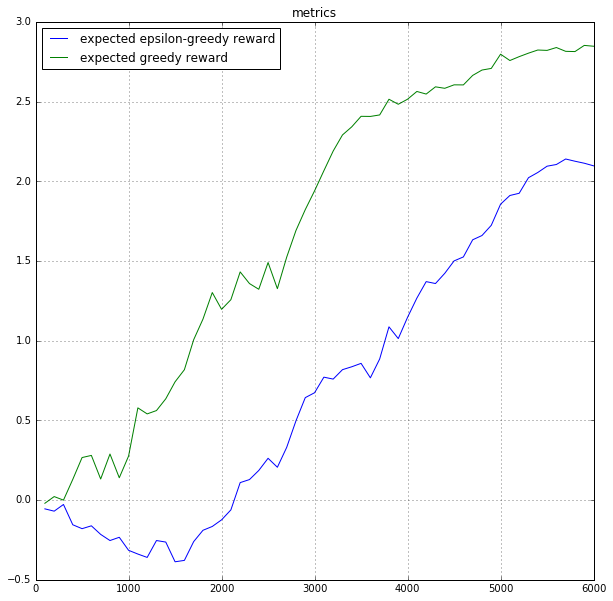

Random session examples
session # 0
 X1(qv = 2.77670574188) -> -1.0 |  Y2(qv = 2.95837068558) -> 3.0 |  End_session_now(qv = -0.00235121231526) -> 0.0 | 



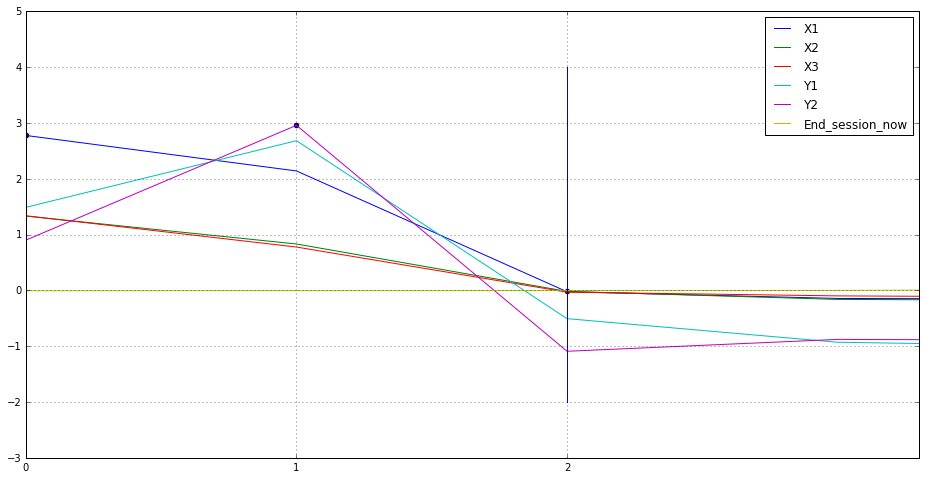

session # 1
 X1(qv = 2.77670574188) -> -1.0 |  Y2(qv = 2.95837068558) -> 3.0 |  End_session_now(qv = -0.00235121231526) -> 0.0 | 



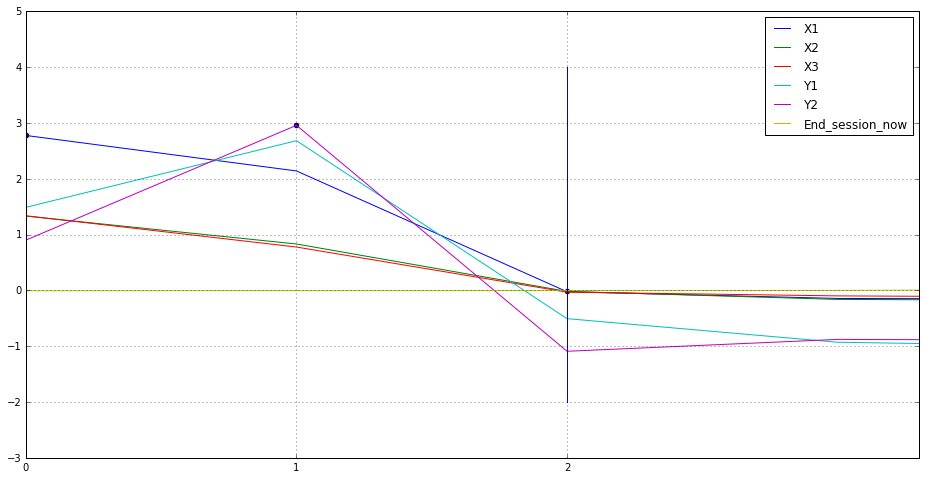

session # 2
 X2(qv = 1.33122336864) -> 1.0 |  Y1(qv = 1.06906425953) -> -3.0 |  Y2(qv = 0.471203923225) -> 3.0 |  X1(qv = -0.648732662201) -> -1.0 |  End_session_now(qv = 0.016282889992) -> 0.0 | 



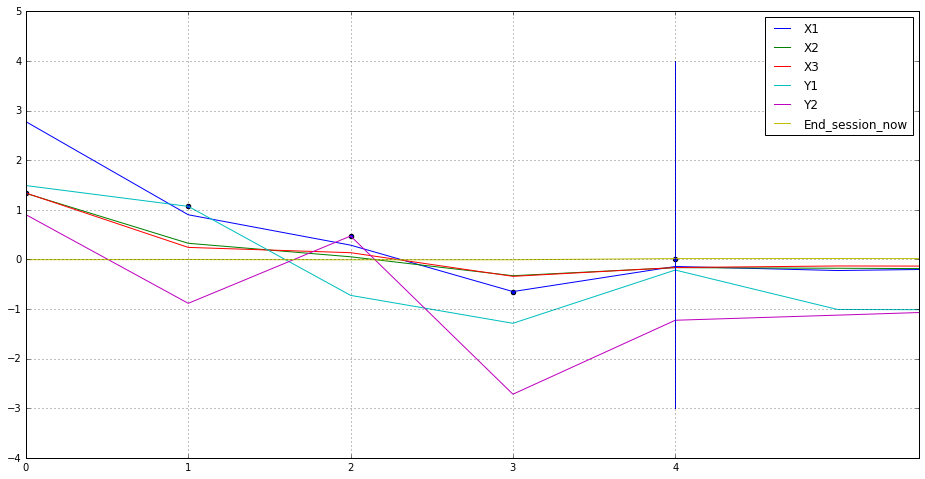

epoch 6100,loss 3.26079, epsilon 0.13280, rewards: ( e-greedy 2.11196, greedy 2.83208) 
rec 3.115 reg 0.146
epoch 6200,loss 0.99669, epsilon 0.12956, rewards: ( e-greedy 2.20077, greedy 2.84887) 
rec 0.850 reg 0.146
epoch 6300,loss 3.07964, epsilon 0.12644, rewards: ( e-greedy 2.24569, greedy 2.94398) 
rec 2.933 reg 0.147
epoch 6400,loss 1.65564, epsilon 0.12344, rewards: ( e-greedy 2.30612, greedy 2.96958) 
rec 1.508 reg 0.148
epoch 6500,loss 2.23548, epsilon 0.12056, rewards: ( e-greedy 2.25051, greedy 2.89262) 
rec 2.087 reg 0.148
epoch 6600,loss 1.48005, epsilon 0.11779, rewards: ( e-greedy 2.34046, greedy 2.92336) 
rec 1.331 reg 0.149
epoch 6700,loss 2.22774, epsilon 0.11513, rewards: ( e-greedy 2.40141, greedy 2.93103) 
rec 2.079 reg 0.149
epoch 6800,loss 1.40136, epsilon 0.11258, rewards: ( e-greedy 2.40127, greedy 2.89792) 
rec 1.252 reg 0.150
epoch 6900,loss 1.89010, epsilon 0.11013, rewards: ( e-greedy 2.40114, greedy 2.86813) 
rec 1.740 reg 0.150
epoch 7000,loss 2.39754, eps

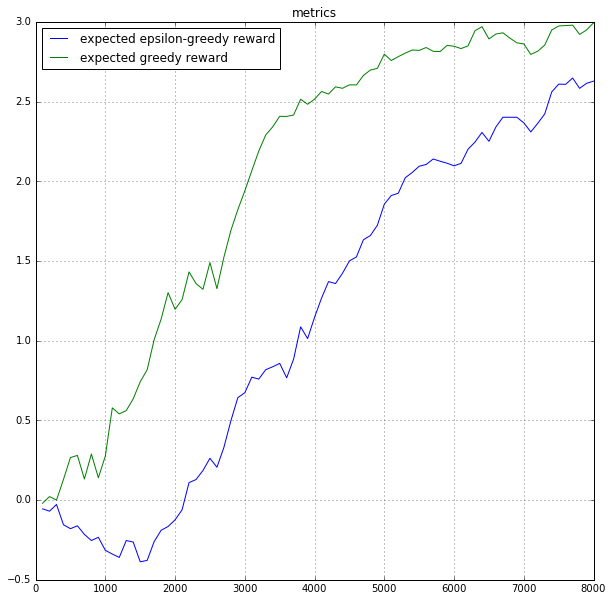

Random session examples
session # 0
 Y1(qv = 1.67163598537) -> 3.0 |  X1(qv = 0.942615389824) -> 1.0 |  Y1(qv = 0.940584659576) -> -0.5 |  End_session_now(qv = -0.01258612331) -> 0.0 | 



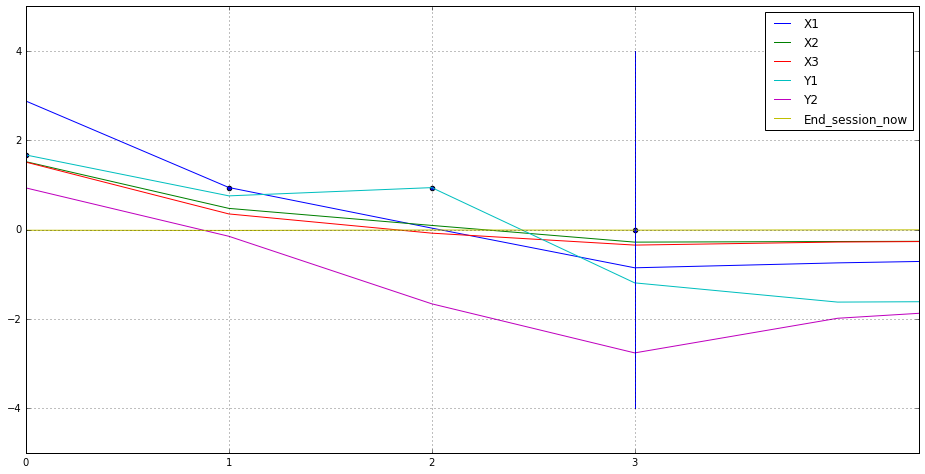

session # 1
 X1(qv = 2.87914156914) -> -1.0 |  Y2(qv = 2.99556899071) -> 3.0 |  X2(qv = 0.0465996861458) -> -1.0 |  X1(qv = -0.264181315899) -> -0.5 |  X1(qv = 0.060622215271) -> -0.5 |  X1(qv = 0.156864374876) -> -0.5 |  Y2(qv = 0.46555814147) -> -0.5 |  End_session_now(qv = -0.0165110453963) -> 0.0 | 



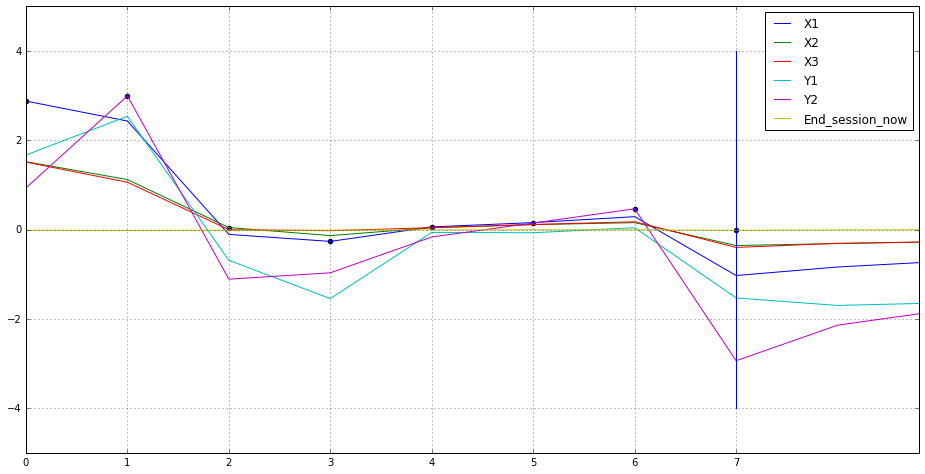

session # 2
 X1(qv = 2.87914156914) -> -1.0 |  Y2(qv = 2.99556899071) -> 3.0 |  X2(qv = 0.0465996265411) -> -1.0 |  End_session_now(qv = -0.012737502344) -> 0.0 | 



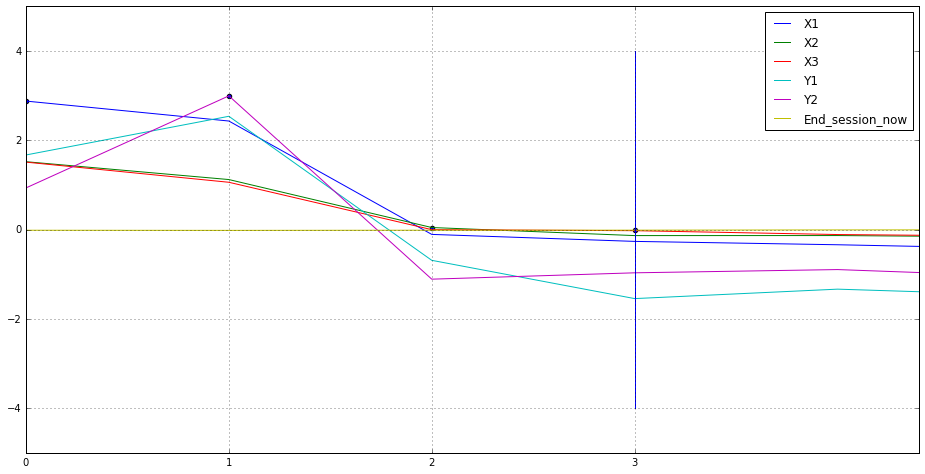

epoch 8100,loss 2.77743, epsilon 0.08721, rewards: ( e-greedy 2.65005, greedy 2.99455) 
rec 2.624 reg 0.153
epoch 8200,loss 1.27683, epsilon 0.08575, rewards: ( e-greedy 2.69504, greedy 2.99509) 
rec 1.124 reg 0.153
epoch 8300,loss 1.27248, epsilon 0.08435, rewards: ( e-greedy 2.72054, greedy 3.01558) 
rec 1.119 reg 0.153
epoch 8400,loss 1.15042, epsilon 0.08300, rewards: ( e-greedy 2.74849, greedy 3.01403) 
rec 0.997 reg 0.153
epoch 8500,loss 1.98189, epsilon 0.08170, rewards: ( e-greedy 2.74364, greedy 2.99262) 
rec 1.828 reg 0.153
epoch 8600,loss 1.13912, epsilon 0.08046, rewards: ( e-greedy 2.76927, greedy 2.99336) 
rec 0.986 reg 0.153
epoch 8700,loss 2.59237, epsilon 0.07927, rewards: ( e-greedy 2.73735, greedy 2.97402) 
rec 2.439 reg 0.153
epoch 8800,loss 1.05432, epsilon 0.07812, rewards: ( e-greedy 2.76361, greedy 2.99662) 
rec 0.900 reg 0.154
epoch 8900,loss 1.51373, epsilon 0.07702, rewards: ( e-greedy 2.79225, greedy 3.03696) 
rec 1.359 reg 0.154
epoch 9000,loss 1.41372, eps

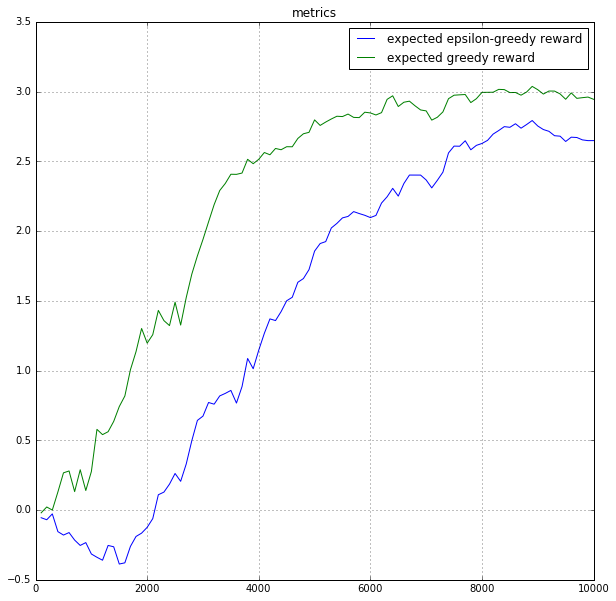

Random session examples
session # 0
 X1(qv = 2.97220873833) -> 1.0 |  Y1(qv = 2.97891640663) -> 3.0 |  End_session_now(qv = 0.0129702305421) -> 0.0 | 



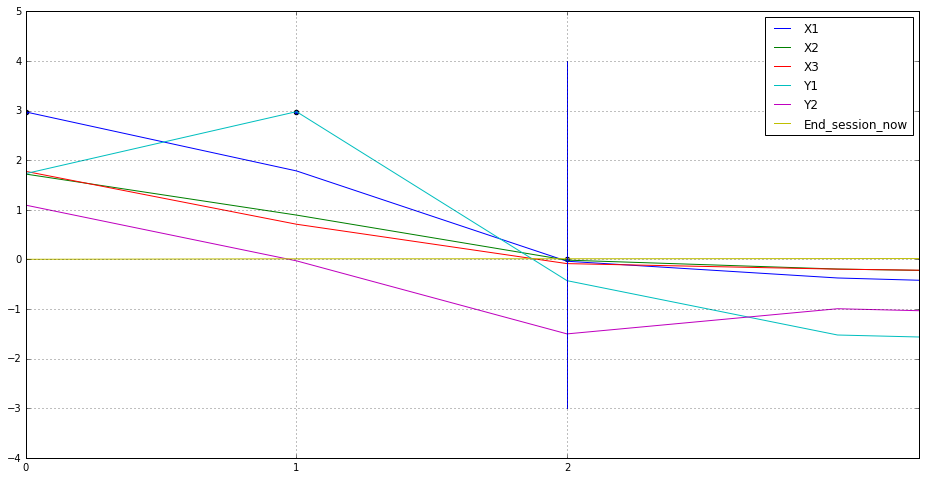

session # 1
 X1(qv = 2.97220873833) -> 1.0 |  Y1(qv = 2.97891640663) -> 3.0 |  End_session_now(qv = 0.0129702305421) -> 0.0 | 



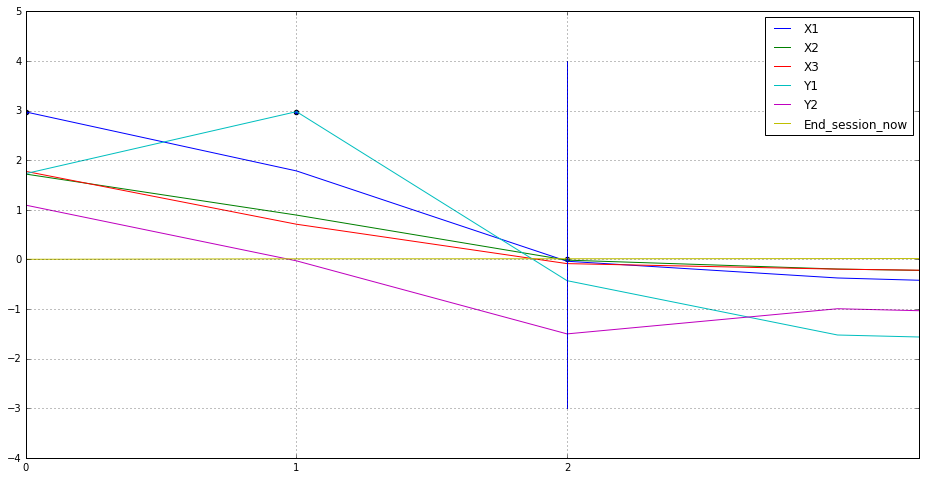

session # 2
 X1(qv = 2.97220873833) -> 1.0 |  Y1(qv = 2.97891640663) -> 3.0 |  End_session_now(qv = 0.0129701783881) -> 0.0 | 



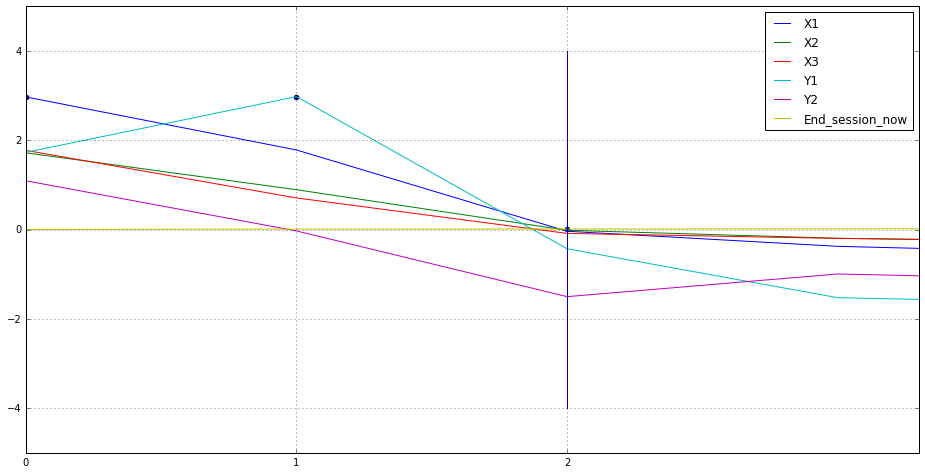

In [19]:
n_epochs = 10000
batch_size=10

for i in range(n_epochs):    
    
    #train
    env.generate_new_data_batch(batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/2500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##show current learning progress
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected epsilon-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

        
    #visualize learning curve and sample sessions
    if epoch_counter %2000 ==0:
        print "Learning curves:"
        score_log.plot()
        
        print "Random session examples"
        env.generate_new_data_batch(3)
        display_sessions(with_plots=True)



        
        
    epoch_counter  +=1


# Evaluate results

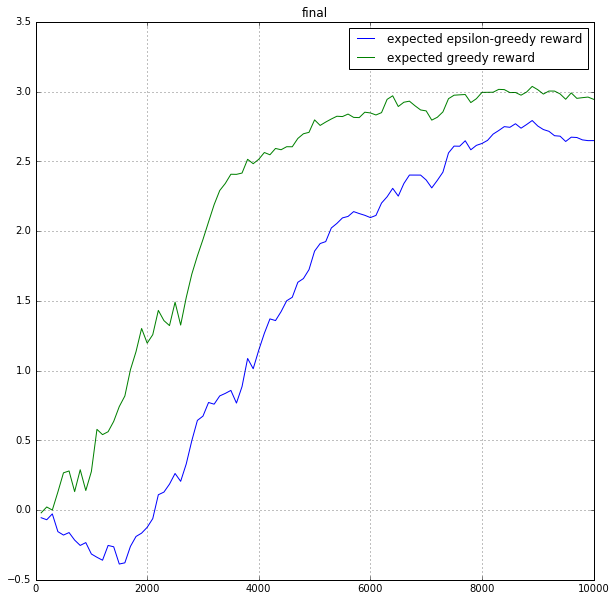

In [20]:
score_log.plot("final")

Random session examples
session # 0
 X1(qv = 2.972209692) -> -1.0 |  Y2(qv = 3.02766561508) -> 3.0 |  End_session_now(qv = 0.0118144145235) -> 0.0 | 



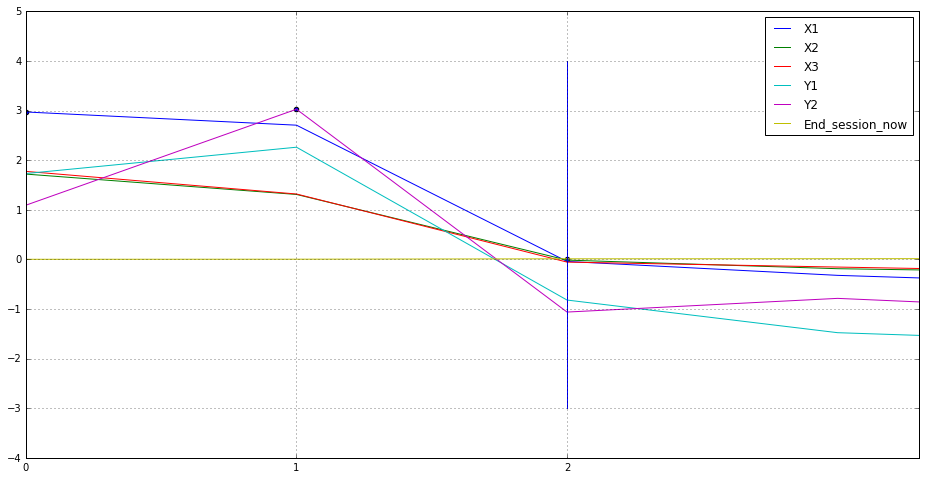

session # 1
 X1(qv = 2.972209692) -> -1.0 |  Y2(qv = 3.02766561508) -> 3.0 |  End_session_now(qv = 0.0118144145235) -> 0.0 | 



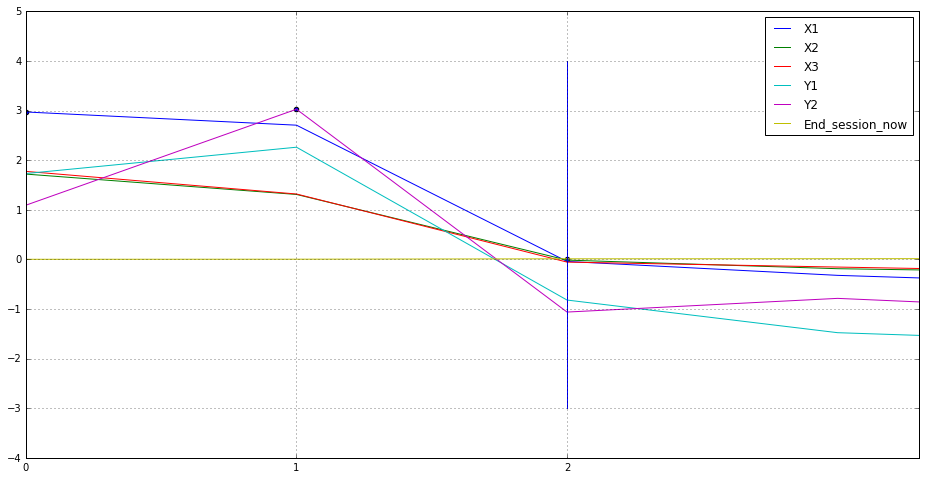

session # 2
 X1(qv = 2.972209692) -> 1.0 |  Y1(qv = 2.97891616821) -> 3.0 |  End_session_now(qv = 0.0129702305421) -> 0.0 | 



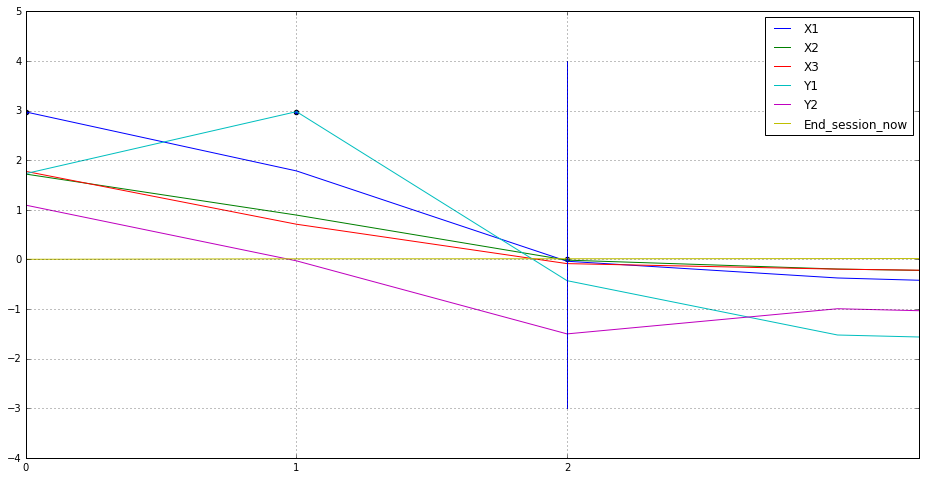

session # 3
 X1(qv = 2.972209692) -> -1.0 |  Y2(qv = 3.02766561508) -> 3.0 |  End_session_now(qv = 0.0118144145235) -> 0.0 | 



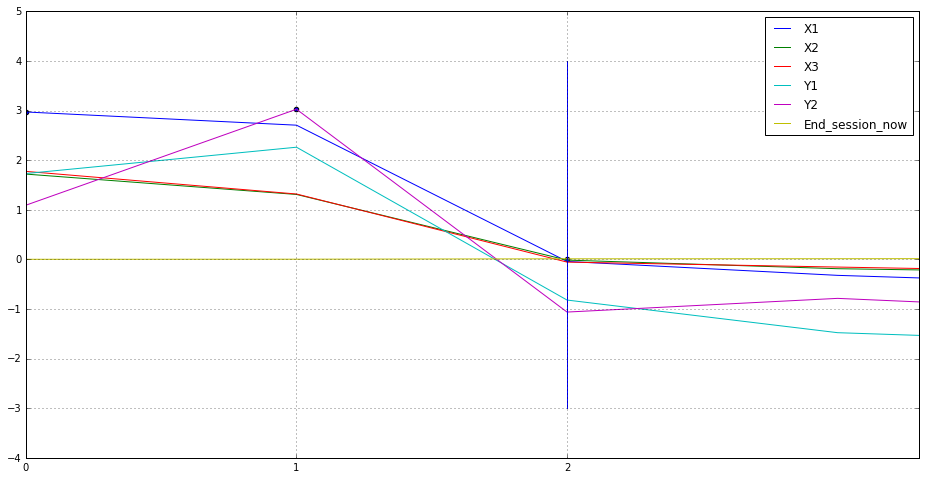

session # 4
 X1(qv = 2.972209692) -> 1.0 |  Y1(qv = 2.97891616821) -> 3.0 |  End_session_now(qv = 0.0129702305421) -> 0.0 | 



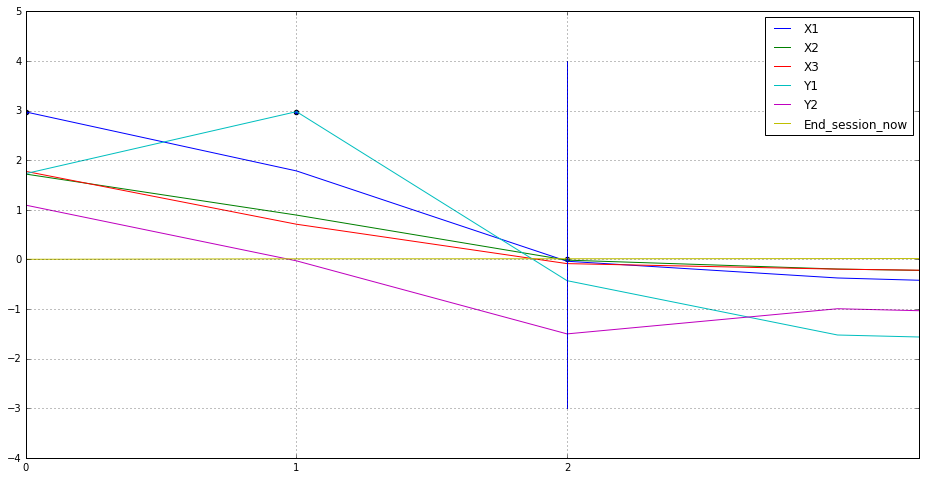

session # 5
 X1(qv = 2.972209692) -> 1.0 |  Y1(qv = 2.97891616821) -> 3.0 |  End_session_now(qv = 0.0129702305421) -> 0.0 | 



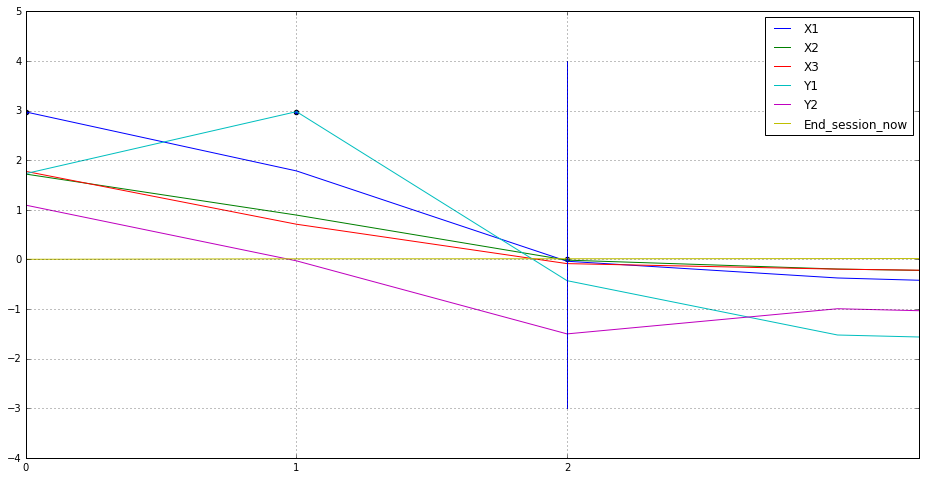

session # 6
 X1(qv = 2.972209692) -> 1.0 |  Y1(qv = 2.97891616821) -> 3.0 |  End_session_now(qv = 0.0129702305421) -> 0.0 | 



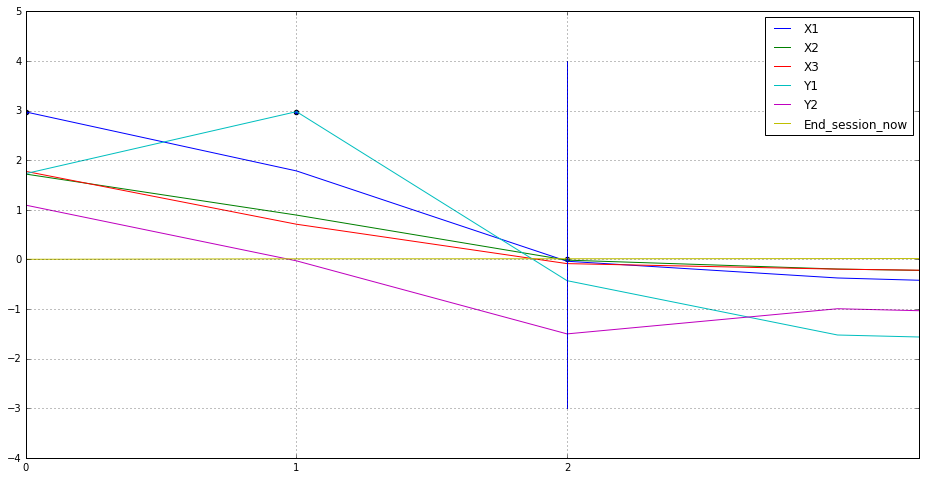

session # 7
 X1(qv = 2.972209692) -> -1.0 |  Y2(qv = 3.02766561508) -> 3.0 |  End_session_now(qv = 0.0118144145235) -> 0.0 | 



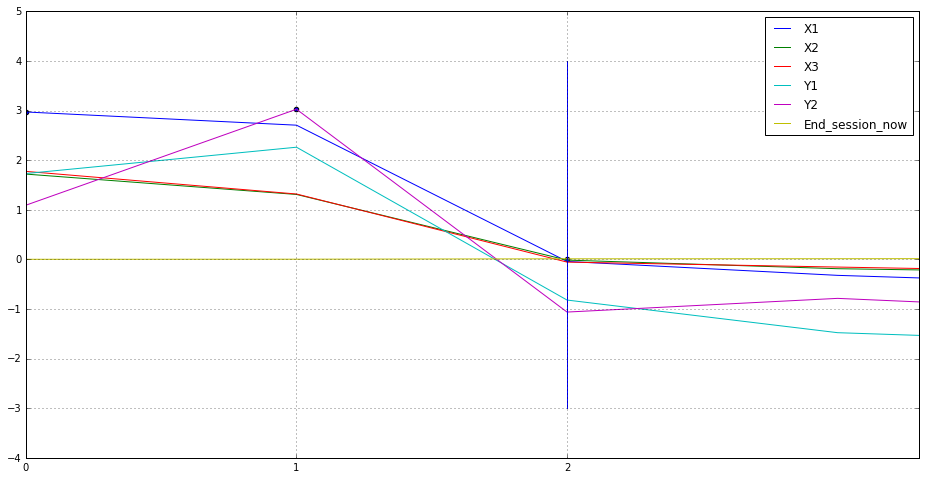

session # 8
 X1(qv = 2.97220873833) -> 1.0 |  Y1(qv = 2.97891640663) -> 3.0 |  End_session_now(qv = 0.0129702305421) -> 0.0 | 



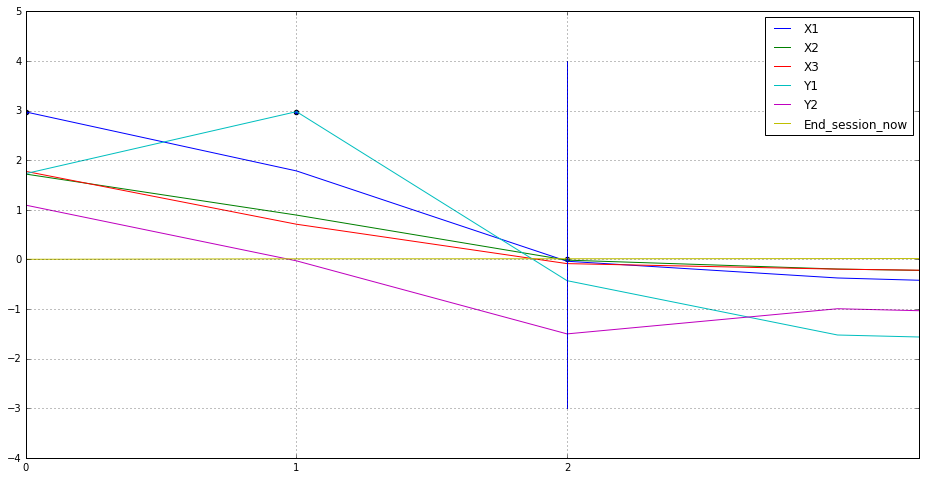

session # 9
 X1(qv = 2.97220873833) -> 1.0 |  Y1(qv = 2.97891640663) -> 3.0 |  End_session_now(qv = 0.0129702305421) -> 0.0 | 



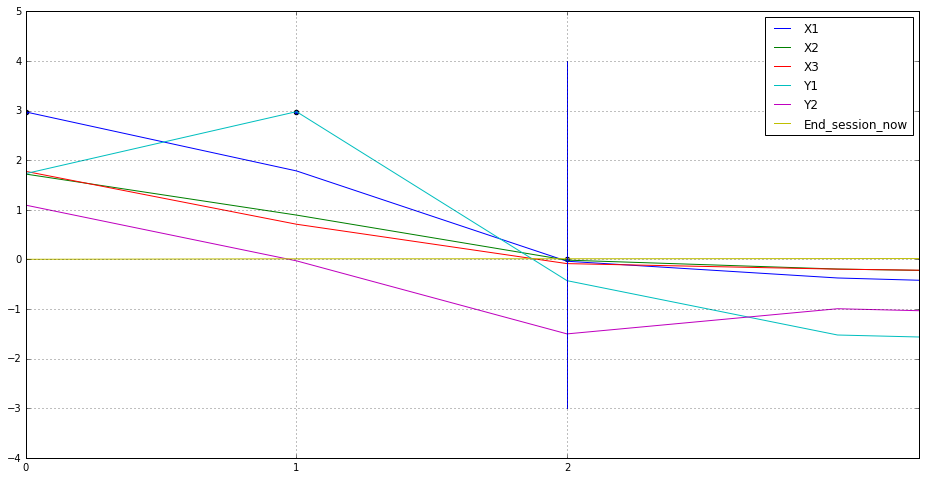

In [21]:
resolver.epsilon.set_value(np.float32(0.))
print "Random session examples"
env.generate_new_data_batch(10)
display_sessions(with_plots=True)
